# Test CNN-VAE (reduction) with Fully-Connected Net (prediction)

In [45]:
import os
from os.path import join
import sys
from pathlib import Path

# include app directory into sys.path
parent_dir = Path(os.path.abspath('')).parent
app_dir = join(parent_dir, "app")
if app_dir not in sys.path:
      sys.path.append(app_dir)

import torch as pt
from torch.nn.functional import mse_loss
import matplotlib.pyplot as plt

import utils.config as config
from utils.CNN_VAE import make_VAE_model
from utils.FullyConnected import make_FC_model
from utils.Scaler import MinMaxScaler_1_1
from utils.TimeSeriesDataset import TimeSeriesDataset

plt.rcParams["figure.dpi"] = 180

# use GPU if possible
device = pt.device("cuda") if pt.cuda.is_available() else pt.device("cpu")
print(device)

DATA_PATH = join(parent_dir, "data", "single_flow_cond")
VAE_PATH = join(parent_dir, "output", "VAE", "latent_study", config.VAE_model)
FC_MODEL = "45_256_1"
FC_PATH = join(parent_dir, "output", "single_flow_cond", "parameter_study", "pred_horizon_1")
LATENT_SIZE = config.VAE_latent_size
OUTPUT_PATH = join(parent_dir, "output", "single_flow_cond")

cpu


#### Load data (single flow condition at alpha = 4.00)

In [46]:
# load datasets
train = pt.load(join(DATA_PATH, "train_dataset.pt"))
test = pt.load(join(DATA_PATH, "test_dataset.pt"))
print(train.shape)
print(test.shape)

torch.Size([256, 128, 400])
torch.Size([256, 128, 100])


#### Load autoencoder and encode data

In [47]:
# load pre-trained autoencoder model
autoencoder = make_VAE_model(
    n_latent=LATENT_SIZE, 
    device=device)
autoencoder.load(VAE_PATH)
autoencoder.eval()
decoder = autoencoder._decoder

# encode datasets
train_enc = autoencoder.encode_dataset(train)
test_enc = autoencoder.encode_dataset(test)
print(test_enc.shape)

torch.Size([32, 100])


#### Load Fully-Connected Net

In [48]:
# results from parameter study
INPUT_WIDTH = 45
HIDDEN_SIZE = 256
N_HIDDEN_LAYERS = 1

FC_model = make_FC_model(
    latent_size=LATENT_SIZE,
    input_width=INPUT_WIDTH, 
    hidden_size=HIDDEN_SIZE, 
    n_hidden_layers=N_HIDDEN_LAYERS
)
print(FC_PATH)
FC_model.load(join(FC_PATH, FC_MODEL + ".pt"))
FC_model.eval()

/home/anton/repositories/Studienarbeit/output/single_flow_cond/parameter_study/pred_horizon_1


FullyConnected(
  (sequential): Sequential(
    (0): Linear(in_features=1440, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
)

#### Scale data and load into TimeSeriesDataset

In [50]:
scaler = MinMaxScaler_1_1().fit(train_enc)
# create TimeSeriesDataset object to create windows of data
# FIXME needs training data to load into TimeSeriesDataset object
timeseriesdataset = TimeSeriesDataset(train=scaler.scale(train_enc), test=scaler.scale(test_enc), input_width=INPUT_WIDTH, pred_horizon=1)
_, target_idx = timeseriesdataset.rolling_window(test_enc.shape[1])
test_enc = timeseriesdataset.test_dataset

In [51]:
study_results = pt.load(join(FC_PATH, "study_results.pt"))
loss_df = study_results[FC_MODEL][0]
print(loss_df)

     train_loss  epoch  total_time  val_loss
0      0.056233      0    0.199648  0.007781
1      0.006260      1    0.260185  0.003841
2      0.003730      2    0.328658  0.002679
3      0.002934      3    0.393173  0.002399
4      0.002987      4    0.458569  0.002283
..          ...    ...         ...       ...
104    0.002304    104    8.127744  0.001886
105    0.002305    105    8.199892  0.001886
106    0.002295    106    8.273697  0.001871
107    0.002278    107    8.352992  0.001895
108    0.002326    108    8.427508  0.001905

[109 rows x 4 columns]


#### Latent Loss vs. Full Space Loss

In [52]:
# compare the latent loss vs the full space MSE predict the whole test dataset and store latent and original loss
latent_loss = []
orig_loss = []

# iterate over the windows of data
for i, (inputs_latent, targets_latent) in enumerate(test_enc):
    inputs_latent = inputs_latent.flatten().to(device)
    targets_latent = targets_latent.flatten().to(device)
    
    with pt.no_grad():
        # time evolution in latent space
        pred_latent = FC_model(inputs_latent)
        latent_loss.append(mse_loss(targets_latent, pred_latent))

        # decoding to full space
        pred_orig = decoder(pred_latent.unsqueeze(0)).squeeze().detach()
        orig_loss.append(mse_loss(test[:, :, target_idx[i].item()], pred_orig))

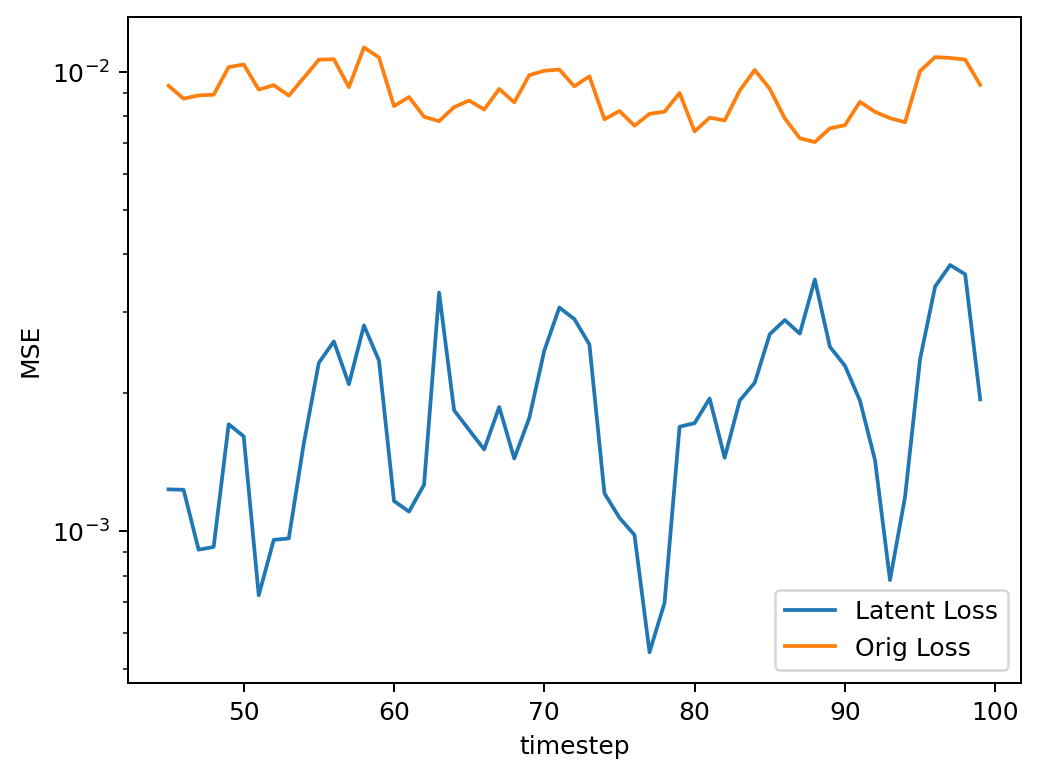

In [62]:
timestep = range(target_idx[0].item(), target_idx[-1].item() + 1)
plt.plot(timestep, latent_loss, label="Latent Loss")
plt.plot(timestep, orig_loss, label="Orig Loss")
plt.ylabel("MSE")
plt.xlabel("timestep")
plt.yscale("log")
plt.legend()

#### Original vs predicted Snapshot

In [54]:
# compare original vs predicted snapshot on test data with subplots(1, 3)[Orig, Predicted, MSE] 

#### Loss vs. Prediction Horizon

In [55]:
# show how the loss of the selected model configuration changes when the prediction horizon increases

#### Test AR prediction

In [56]:
# decide on architecture and predict an arbitrary timestep -> compare to actual timestep